# Chapter 8. Inferene Engines

In [1]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import jax.numpy as jnp
from jax import random, vmap, local_device_count, pmap, lax, tree_map
from jax import nn as jnn
from jax.scipy import stats, special

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim

from numpyro.infer import MCMC, NUTS, HMC, Predictive
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation

seed=1234

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(
    category.__name__, message
)
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu") # or "gpu", "tpu" depending on system
numpyro.set_host_device_count(local_device_count())

In [1]:
# import pymc3 as pm
# import numpy as np
# import pandas as pd
# import scipy.stats as stats
# import matplotlib.pyplot as plt
# import arviz as az

In [2]:
# az.style.use('arviz-darkgrid')

## Non-Markovian methods

### Grid computing


In [95]:
def posterior_grid(grid_points=50, heads=6, tails=9):
    """ 
    A grid implementation for the coin-flipping problem 
    """
    grid = jnp.linspace(0.01, 1, grid_points)
    prior = jnp.repeat(1/grid_points, grid_points)  # uniform prior
    likelihood = jnp.exp(dist.Binomial(total_count=(heads+tails), probs=grid).log_prob(heads))
    posterior = likelihood * prior
    posterior /= posterior.sum()
    return grid, posterior

Assuming we flip a coin 13 times and we observed 3 head we have:

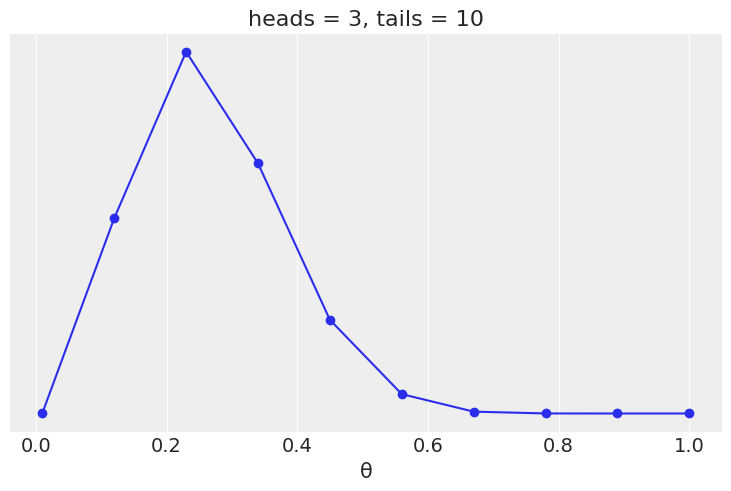

In [100]:
data = jnp.repeat(jnp.array([0, 1]), jnp.asarray((10, 3)))
points = 10
h = data.sum()
t = len(data) - h
grid, posterior = posterior_grid(points, h, t) 

plt.plot(grid, posterior, 'o-')

plt.title(f'heads = {h}, tails = {t}')
plt.yticks([])
plt.xlabel('θ');

### Quadratic method

In [108]:
def model(obs=None):
    p = numpyro.sample('p', dist.Beta(concentration1=1., concentration0=1.))
    w = numpyro.sample('w', dist.Binomial(total_count=1, probs=p), obs=obs)
                       
lp = AutoLaplaceApproximation(model)
svi = SVI(model, lp, optim.Adam(1), Trace_ELBO(), obs=data)
svi_result = svi.run(random.PRNGKey(0), 2000)
params = svi_result.params

100%|█████████████████████████| 2000/2000 [00:00<00:00, 3224.05it/s, init loss: 11.2695, avg. loss [1901-2000]: 8.6987]


In [111]:
samples = lp.sample_posterior(random.PRNGKey(1), params, (1000,))

In [119]:
a_map = jnp.mean(samples["p"])

In [122]:
a_map

DeviceArray(0.2752923, dtype=float32)

In [5]:
with pm.Model() as normal_aproximation:
    p = pm.Beta('p', 1., 1.)
    w = pm.Binomial('w',n=1, p=p, observed=data)
    mean_q = pm.find_MAP()
    std_q = ((1/pm.find_hessian(mean_q, vars=[p]))**0.5)[0]
mean_q['p'], std_q

/home/osvaldo/proyectos/00_PyMC3/pymc3/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -9.0109, ||grad|| = 3.5: 100%|██████████| 7/7 [00:00<00:00, 664.63it/s]


(array(0.23076923), array([0.11685454]))

In [125]:
mean_q = {}
mean_q['p'] = jnp.array(0.23076923)
std_q = jnp.array(0.11685454)

([], [])

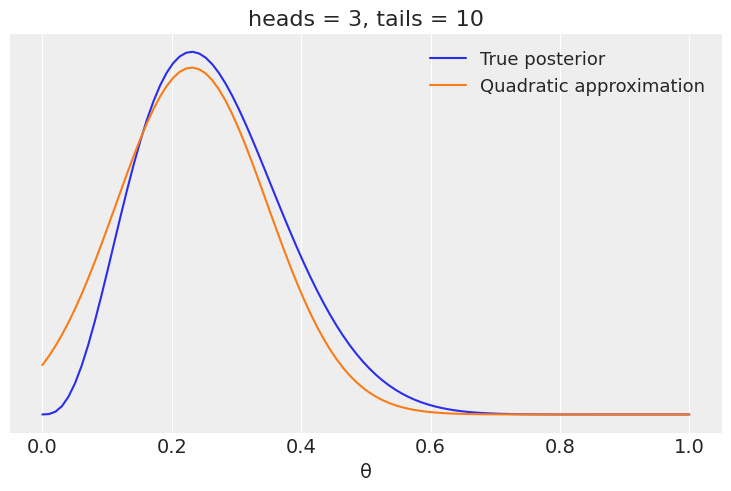

In [126]:
# analytical calculation
x = jnp.linspace(0, 1, 100)
plt.plot(x, jnp.exp(dist.Beta(h+1, t+1).log_prob(x)), label='True posterior')

# quadratic approximation
plt.plot(x, jnp.exp(dist.Normal(mean_q['p'], std_q).log_prob(x)),label='Quadratic approximation')
plt.legend(loc=0, fontsize=13)

plt.title(f'heads = {h}, tails = {t}')
plt.xlabel('θ', fontsize=14)
plt.yticks([])

## Markovian methods

### Monte Carlo


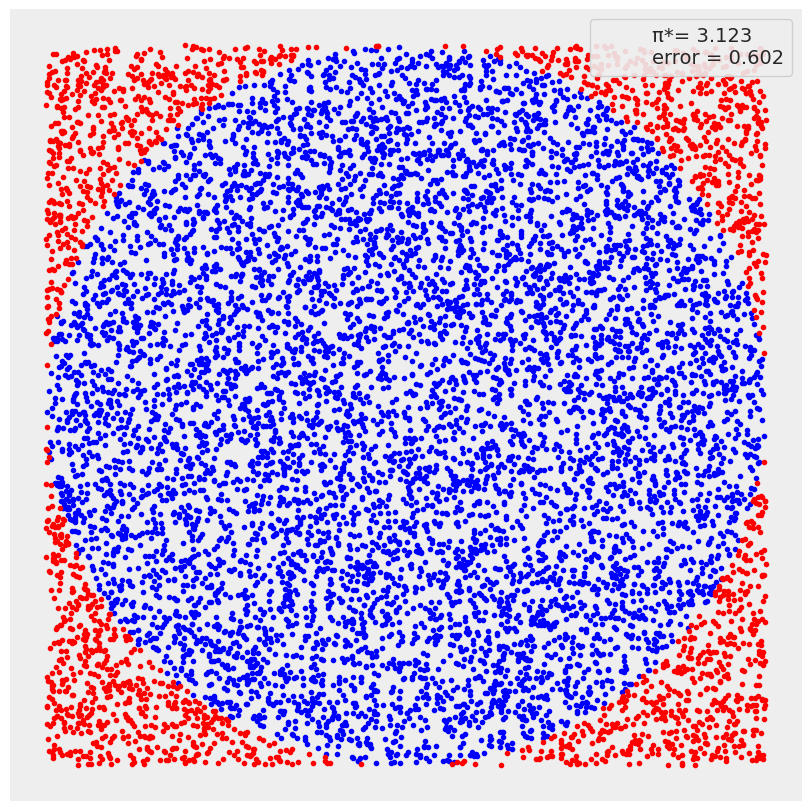

In [129]:
N = 10000

x, y = dist.Uniform(low=-1, high=1).sample(random.PRNGKey(0), sample_shape=(2, N))
inside = (x**2 + y**2) <= 1
pi = inside.sum()*4/N
error = abs((pi - jnp.pi) / pi) * 100
 
outside = jnp.invert(inside)
 
plt.figure(figsize=(8, 8))
plt.plot(x[inside], y[inside], 'b.')
plt.plot(x[outside], y[outside], 'r.')
plt.plot(0, 0, label=f'π*= {pi:4.3f}\nerror = {error:4.3f}', alpha=0)
plt.axis('square')
plt.xticks([])
plt.yticks([])
plt.legend(loc=1, frameon=True, framealpha=0.9)

In [132]:
def metropolis(func, draws=10000):
    """A very simple Metropolis implementation"""
    trace = jnp.zeros(draws)
    old_x = 0.5  # func.mean()
    old_prob = jnp.exp(func.log_prob(old_x))

    delta = dist.Normal(loc=0, scale=0.5).sample(random.PRNGKey(0), sample_shape=draws)
    for i in range(draws):
        new_x = old_x + delta[i]
        new_prob = jnp.exp(func.log_prob(new_x))
        acceptance = new_prob / old_prob
        if acceptance >= np.random.random():
            trace[i] = new_x
            old_x = new_x
            old_prob = new_prob
        else:
            trace[i] = old_x

    return trace

In [133]:
np.random.seed(3)
func = dist.Beta(concentration1=2, concentration0=5)
# stats.beta(2, 5) 
trace = metropolis(func=func) 
x = jnp.linspace(0.01, .99, 100) 
y = jnp.exp(func.log_porb(x)) 
plt.xlim(0, 1) 
plt.plot(x, y, 'C1-', lw=3, label='True distribution') 
plt.hist(trace[trace > 0], bins=25, density=True, label='Estimated distribution') 
plt.xlabel('x') 
plt.ylabel('pdf(x)')
plt.yticks([]) 
plt.legend()
# plt.savefig('B11197_08_05.png');

TypeError: unsupported operand type(s) for +: 'int' and 'tuple'

## Diagnosing the samples

In [10]:
with pm.Model() as centered_model:
    a = pm.HalfNormal('a', 10)
    b = pm.Normal('b', 0, a, shape=10)
    trace_cm = pm.sample(2000, random_seed=7)

with pm.Model() as non_centered_model:
    a = pm.HalfNormal('a', 10)

    b_offset = pm.Normal('b_offset', mu=0, sd=1, shape=10)
    b = pm.Deterministic('b', 0 + b_offset * a)
    trace_ncm = pm.sample(2000, random_seed=7)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:09<00:00, 553.45draws/s]
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5465674186441168, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b_offset, a]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:05<00:00, 911.07draws/s] 


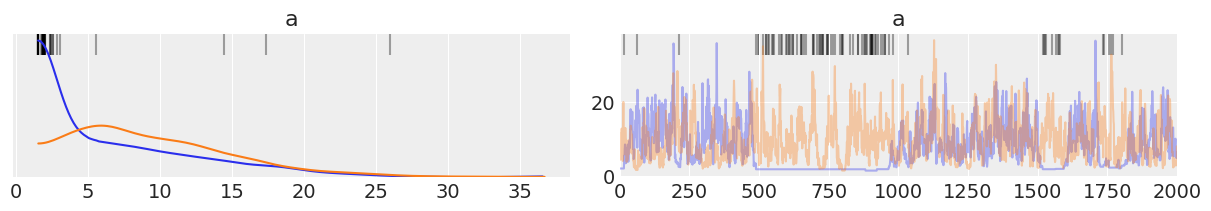

In [11]:
az.plot_trace(trace_cm, var_names=['a'], divergences='top')
plt.savefig('B11197_08_07.png');

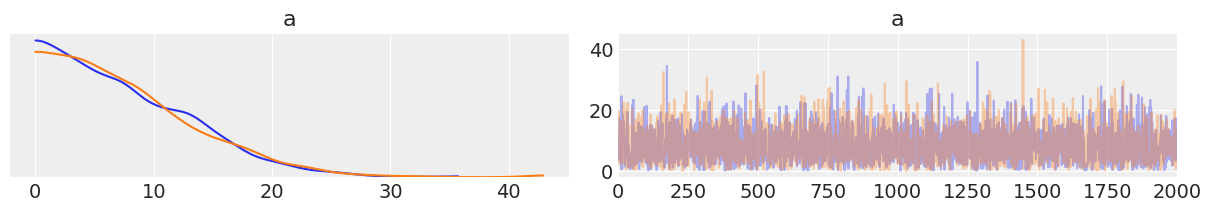

In [12]:
az.plot_trace(trace_ncm, var_names=['a'])
plt.savefig('B11197_08_08.png');

In [13]:
az.gelman_rubin(trace_cm)['a'].values

array(1.04)

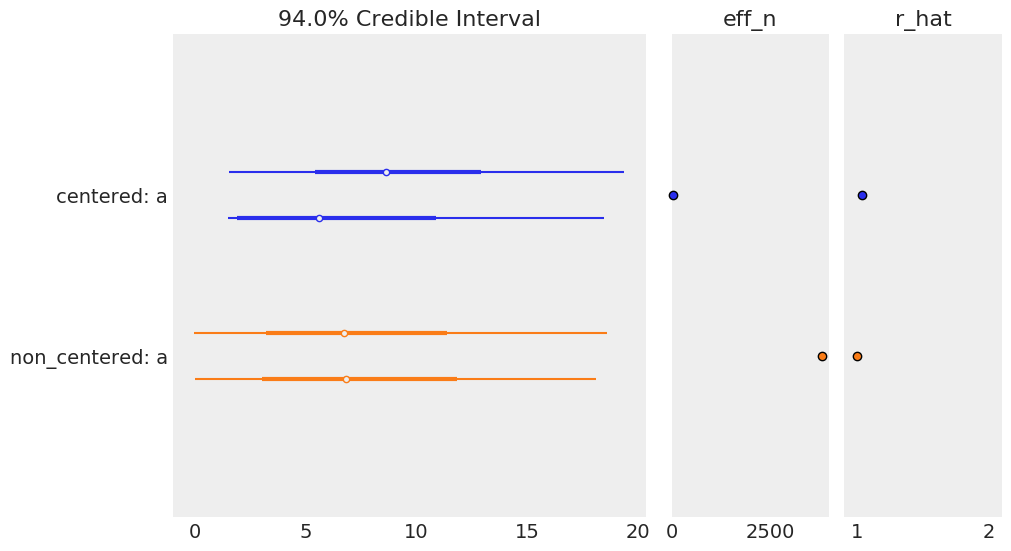

In [14]:
az.plot_forest([trace_cm, trace_ncm], model_names=['centered', 'non_centered'],
               var_names=['a'], r_hat=True, eff_n=True)
plt.savefig('B11197_08_10.png')

In [15]:
summaries = pd.concat([az.summary(trace_cm, var_names=['a']),
           az.summary(trace_ncm, var_names=['a'])])
summaries.index = ['centered', 'non_centered']
summaries

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
centered,8.53,5.84,0.58,1.53,18.87,49.0,1.04
non_centered,7.92,6.01,0.04,0.01,18.48,3817.0,1.00


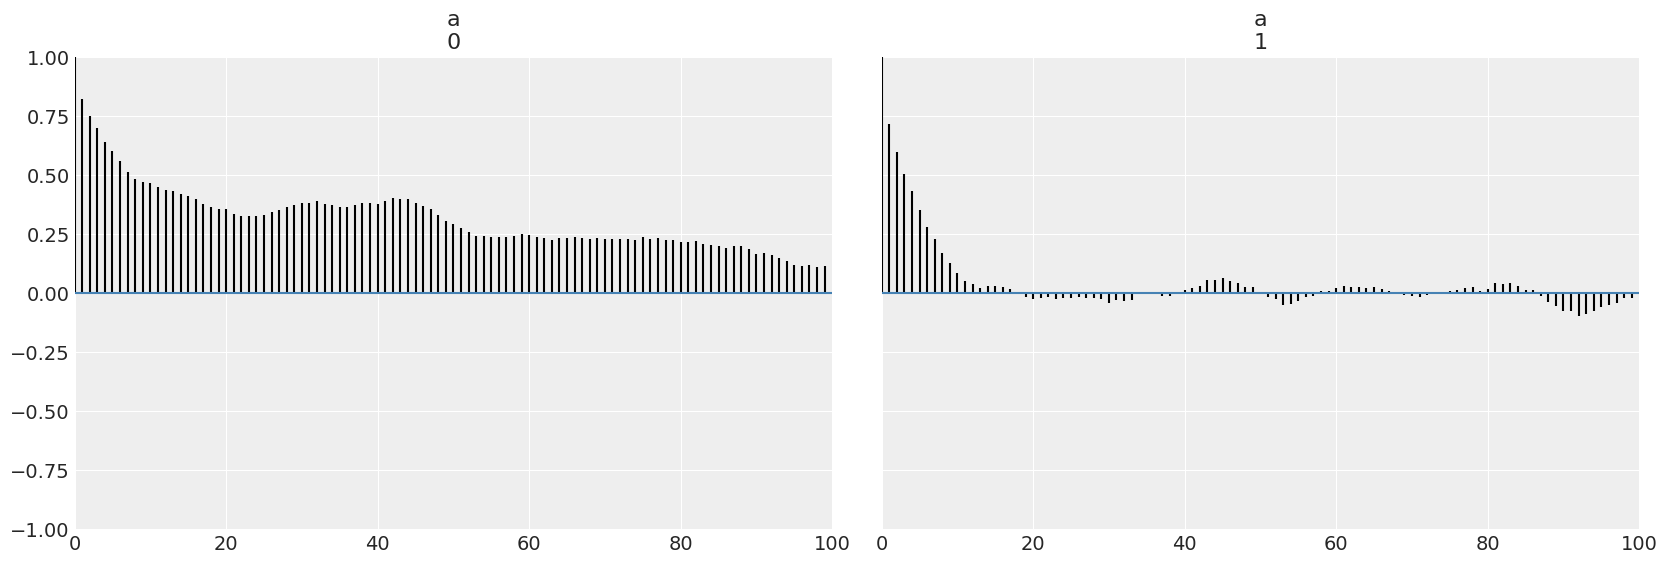

In [16]:
az.plot_autocorr(trace_cm, var_names=['a'])
plt.savefig('B11197_08_11.png');

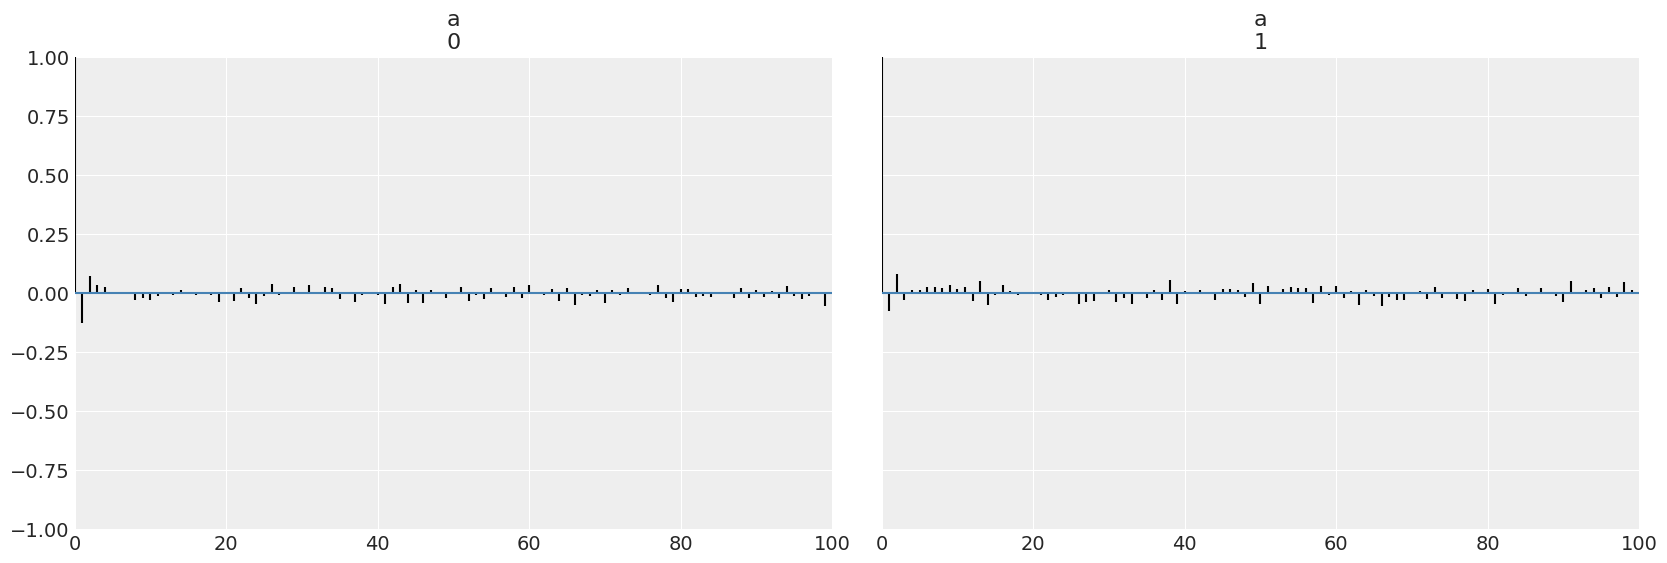

In [17]:
az.plot_autocorr(trace_ncm, var_names=['a'])
plt.savefig('B11197_08_12.png');

## Effective sample size

In [18]:
az.effective_n(trace_cm)['a'].values

array(49.)

## Divergences

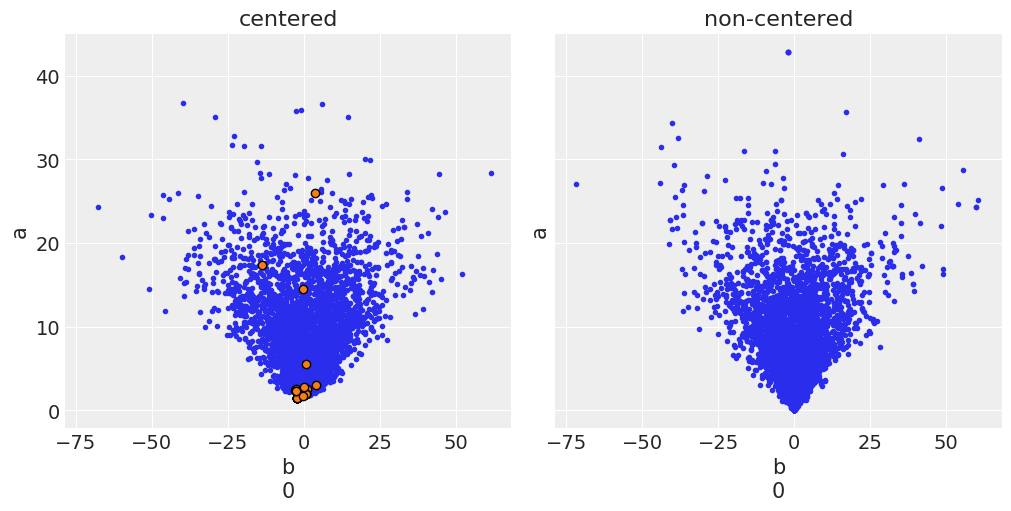

In [19]:
_, ax = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10, 5), constrained_layout=True)

for idx, tr in enumerate([trace_cm, trace_ncm]):
    az.plot_pair(tr, var_names=['b', 'a'], coords={'b_dim_0':[0]}, kind='scatter',
                 divergences=True, contour=False, divergences_kwargs={'color':'C1'},
                 ax=ax[idx])
    ax[idx].set_title(['centered', 'non-centered'][idx])
plt.savefig('B11197_08_13.png');

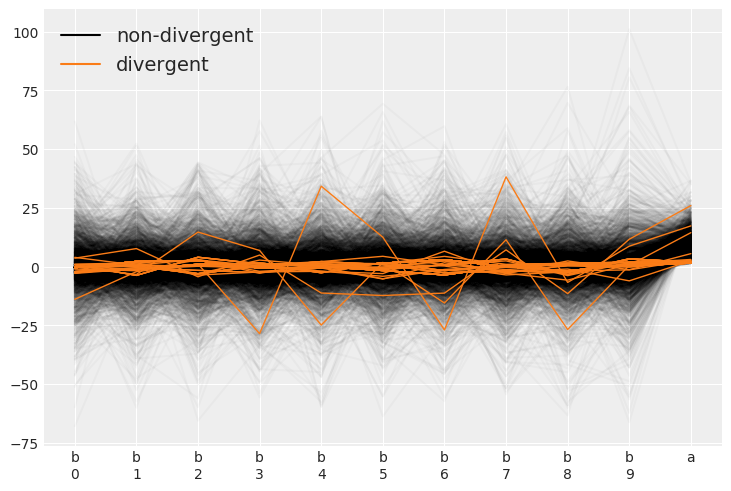

In [20]:
az.plot_parallel(trace_cm)
plt.savefig('B11197_08_14.png');